<h1>Step 0: import module for bert_QA project</h1>

In [30]:
#step 0
import json
import os
from dataset import read_jsonl
import re
# step 1
from sklearn.model_selection import train_test_split
# step 4
from transformers import AutoTokenizer, BertForQuestionAnswering
from transformers import AdamW
# step 6
import torch as th
# step 7
from torch.utils.data import DataLoader
# step 10
import time
from torch.utils.tensorboard import SummaryWriter

os.chdir('/home/sangmin/grade-school-math/grade_school_math/')

<h1>Step 1: Retrieve and Store the data</h1>
Here I take and store the texts, queries and answers from the train and validation .json files. I save these informations into lists.

In [31]:
path = os.path.join("data/train.jsonl")
objs = read_jsonl(path)

texts = []
queries = []
answers = []

for i in objs:

    answer_info = {}

    an = i['answer']
    co = re.findall('.+\n#', an)
    ans = re.findall('\d+$', an)

    context = co[0]
    answer_info['text'] = ans[0]
    answer_info['answer_start'] = context.rfind('>>') + 2
    question = i['question']
        
    texts.append(context)
    answers.append(answer_info)
    queries.append(question)

train_texts, val_texts, train_queries, val_queries, train_answers, val_answers = train_test_split(texts, queries, answers, test_size=0.15, shuffle=True)

#{'question': 'Nina enjoys keeping insects as pets. She has 3 spiders and 50 ants. Each spider has 8 eyes. Each ant has 2 eyes. How many eyes are there in total among Nina’s pet insects?', 
#'answer': 'The number of eyes from the spiders is 3 * 8 = <<3*8=24>>24 eyes\nThe number of eyes from the ants is 50 * 2 = <<50*2=100>>100 eyes\nThe total number of eyes among Nina’s insects is 24 + 100 = <<24+100=124>>124 eyes\n#### 124'}


<H1>Step 2: Check the data</H1>

As you can see we have 7473 passages, queries and answers from the training data. The answer is stored in a dictionary with the specific answer in the "text" cell and the accurate character index that the answer is started in cell "answer start". As we observe, we need to fill the information about the exact index of the character that the answer is ending from the referance.

In [32]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

6352
6352
6352


In [33]:
print("Passage: ",train_texts[0:2])  
print("Query: ",train_queries[0:2])
print("Answer: ",train_answers[0:2])

Passage:  ['Therefore (Number of Minutes) = 4\n#', "A quarter of this time is spent on commercials, so that's 180 minutes / 4 = <<180/4=45>>45 minutes\n#"]
Query:  ["Erik's dog can run 24 miles per hour. It is chasing a rabbit that can run 15 miles per hour. The rabbit has a head start of .6 miles. How many minutes does it take for the dog to catch up to the rabbit?", 'One-fourth of the airing time of a television program is spent on commercials. If there are 6 thirty-minute programs, how many minutes are spent on commercials for the whole duration of the 6 programs?']
Answer:  [{'text': '4', 'answer_start': 1}, {'text': '45', 'answer_start': 88}]


In [34]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

1121
1121
1121


In [35]:
print("Passage: ",val_texts[1])  
print("Query: ",val_queries[1])
print("Answer: ",val_answers[1])

Passage:  There are 24 more children than adults because 72 - 48 = <<72-48=24>>24
#
Query:  A church has 120 members. 40% are adults. The rest are children. How many children more children are there than adults?
Answer:  {'text': '24', 'answer_start': 69}


<h1>Step 3: Find the end position character</h1>
Because Bert model needs both start and end position characters of the answer, I have to find it and store it for later. 

In [36]:
#Find end position character in train data.
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    end_idx = start_idx + len(real_answer) -1
    answer['answer_end'] = end_idx

In [37]:
#Find end position character in valid data.
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    end_idx = start_idx + len(real_answer) -1
    answer['answer_end'] = end_idx

In [38]:
#double check for data including answer_end index
print("Passage: ",train_texts[0:2])  
print("Query: ",train_queries[0:2])
print("Answer: ",train_answers[0:2])

Passage:  ['Therefore (Number of Minutes) = 4\n#', "A quarter of this time is spent on commercials, so that's 180 minutes / 4 = <<180/4=45>>45 minutes\n#"]
Query:  ["Erik's dog can run 24 miles per hour. It is chasing a rabbit that can run 15 miles per hour. The rabbit has a head start of .6 miles. How many minutes does it take for the dog to catch up to the rabbit?", 'One-fourth of the airing time of a television program is spent on commercials. If there are 6 thirty-minute programs, how many minutes are spent on commercials for the whole duration of the 6 programs?']
Answer:  [{'text': '4', 'answer_start': 1, 'answer_end': 1}, {'text': '45', 'answer_start': 88, 'answer_end': 89}]


<h1>Step 4: Tokenize passages and queries</h1>
In this task is asked to select the BERT-base pretrained model “bert-base-uncased” for the tokenization

In [39]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

<h1>Step 5: Convert the start-end positions to tokens start-end positions</h1>
In this task is asked to select the BERT-base pretrained model “bert-base-uncased” for the tokenization

In [40]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  count = 0
  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
      
    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print(count)

  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

0
0


In [41]:
train_encodings[0]

Encoding(num_tokens=253, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

<h1>Step 6: Create a Dataset class</h1>
Create a GSM8Kdataset class for BERT (inherits from torch.utils.data.Dataset), that helped me to train and validate my previous data more easily and convert encodings to datasets.

In [42]:
class gsm8kDataset(th.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: th.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [43]:
train_dataset = gsm8kDataset(train_encodings)
val_dataset = gsm8kDataset(val_encodings)

In [44]:
# for key, val in train_encodings.items():
#     print({key: th.tensor(val[1])} )

<h1>Step 7: Use of DataLoader</h1>
I put my previous data to DataLoader, so as to split them in "pieces" of 8 batch size. I will explain the selection of this value of batch size later.

In [45]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

<h1>Step 8: Use GPU</h1>

In [46]:
device = th.device('cuda:0' if th.cuda.is_available()
                      else 'cpu')

<h1>Step 9: Build the Bert model</h1>

In [47]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
epochs = 5
# epochs = 4

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

<h1>Step 10: Train and Evaluate Model</h1>


In [48]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

# writer = SummaryWriter() #for visualization.

for epoch in range(epochs):
  epoch_time = time.time()

  # Set model in train mode
  model.train()
    
  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader): 
    
    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # writer.add_scalar("Loss/train", loss, epoch)
    # do a backwards pass 
    loss.backward()
    # update the weights
    optim.step()
    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  ##########Evaluation##################

  # Set model in evaluation mode
  model.eval()

  print("############Evaluate############")

  loss_of_epoch = 0

  for batch_idx,batch in enumerate(val_loader):
    
    with th.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)
      
      outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      # writer.add_scalar("Loss/val", loss, epoch)
      # Find the total loss
      loss_of_epoch += loss.item()

    # if (batch_idx+1) % print_every == 0:
    #    print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(val_loader)
  val_losses.append(loss_of_epoch)

  # Print each epoch's time and train/val loss 
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))
# writer.close()

############Train############
Batch 1000 / 1588 
Loss: 0.0 

############Evaluate############

-------Epoch  1 -------
Training Loss: 0.10510487643481409 
Validation Loss: 0.02983678684055296 
Time:  97.90031433105469 
----------------------- 


############Train############
Batch 1000 / 1588 
Loss: 0.0 

############Evaluate############

-------Epoch  2 -------
Training Loss: 0.0454421562862486 
Validation Loss: 0.03903035874568834 
Time:  96.94937419891357 
----------------------- 


############Train############
Batch 1000 / 1588 
Loss: 0.2 

############Evaluate############

-------Epoch  3 -------
Training Loss: 0.04325524010956171 
Validation Loss: 0.029715275485882896 
Time:  96.83696913719177 
----------------------- 


############Train############
Batch 1000 / 1588 
Loss: 0.0 

############Evaluate############

-------Epoch  4 -------
Training Loss: 0.03597263681101291 
Validation Loss: 0.041760344591062724 
Time:  96.18105220794678 
----------------------- 


############Tra

<h1>Step 11: Visualization</h1>

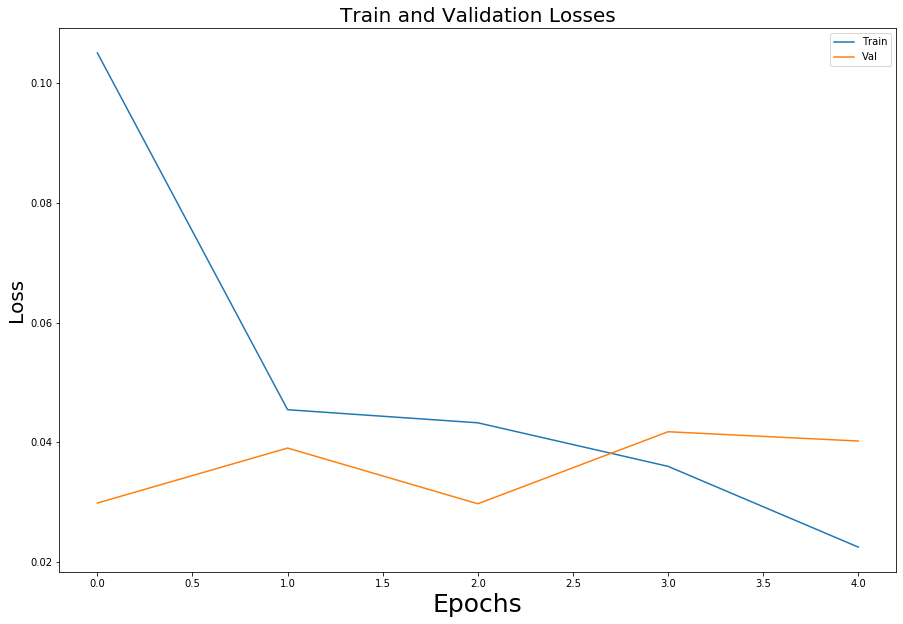

In [49]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
ax.plot(train_losses)
ax.plot(val_losses)
ax.legend(('Train','Val'),loc='upper right')

<h1>TEST</H1>

In [50]:
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

<H1>Make the prediction and evaluate it</H1>

In [111]:
def predict(context,query):
  
  inputs = tokenizer.encode_plus(query, context, return_tensors='pt')

  with th.no_grad():
    outputs = model(**inputs).to(device)

  answer_start = th.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
  answer_end = th.argmax(outputs[1]) + 1 

  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

  return answer

def normalize_text(s):
  """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
  import string, re

  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)

  def white_space_fix(text):
    return " ".join(text.split())

  def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)

  def lower(text):
    return text.lower()

  return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
  pred_tokens = normalize_text(prediction).split()
  truth_tokens = normalize_text(truth).split()
  
  # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)
  
  common_tokens = set(pred_tokens) & set(truth_tokens)
  
  # if there are no common tokens then f1 = 0
  if len(common_tokens) == 0:
    return 0
  
  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)
  
  return 2 * (prec * rec) / (prec + rec)

In [96]:
def give_an_answer(context,query,answer):

  prediction = predict(context,query)
  em_score = compute_exact_match(prediction, answer)
  f1_score = compute_f1(prediction, answer)

  print(f"Question: {query}")
  print(f"Prediction: {prediction}")
  print(f"True Answer: {answer}")
  print(f"EM: {em_score}")
  print(f"F1: {f1_score}")
  print("\n")

<H1>Test my model</H1>
Here I give some examples to my model to see how well I trained it. I started with more easier examples and then I gave it more complex ones.

For extractive textual QA tasks, we usually adopt two evaluation metrics, which measure exact match and partially overlapped scores respectively. also EM is more reasonable for GSM8K data

- EM(Exact Match) : measures whether the predicted answer exactly matches the ground-truth answers. If the exact matching occurs, then assigns 1.0, otherwise assigns 0.0.
- F1 Score : computes the average word overlap between predicted and ground-truth answers, which can ensure both of precision and recall rate are optimized at the same time.

In [97]:
# this is test dataset
path = os.path.join("data/test.jsonl")
objs = read_jsonl(path)

texts = []
queries = []
answers = []

for i in objs:

    answer_info = {}

    an = i['answer']
    co = re.findall('.+\n#', an)
    ans = re.findall('\d+$', an)

    context = co[0]
    answer_info['text'] = ans[0]
    answer_info['answer_start'] = context.rfind('>>') + 2
    question = i['question']
        
    texts.append(context)
    answers.append(answer_info)
    queries.append(question)

test_texts, test_queries, test_answers = texts, queries, answers

In [65]:
# test_queries[0]
test_answers[0]['text']
test_texts

'18'

In [84]:
# q = test_queries[0]
# q
# test_texts[0]
a = test_answers[0]['text']
[a]

['18']

In [108]:
context = 'She makes 9 * 2  == $<<9*2=18>>18 every day at the farmer’s market.\n#'
queries = 'Janets ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers market?'
queries = [queries]
answers ='18'
answers = [answers]
answers

['18']

In [114]:
for q,a in zip(queries.to(device), answers.to(device)):
  give_an_answer(context,q,a)

AttributeError: 'list' object has no attribute 'to'

In [83]:
for q,a in zip(test_queries[0],test_answers[0]['text']):
  give_an_answer(test_texts[0],q,a)

RuntimeError: Input, output and indices must be on the current device

In [55]:
a= 'abc dedf gefj'
b = a.split()
type(b)

list